In [1]:
# Simple text Processing.
# Classifying if comments are toxic or non_toxic (2_class Classification)

In [2]:
# Get the data
! wget https://raw.githubusercontent.com/neychev/harbour_dlia2020/master/day01/utils.py -nc

File ‘utils.py’ already there; not retrieving.



In [3]:
import matplotlib.pyplot as plt #Plotting
import numpy as np              #Linear Algebra
import os                       #Directory access
import pandas as pd             #Data manipulation and processing

In [4]:
# Verify the data is present
try:
    data = pd.read_csv('../datasets/comments_small_dataset/comments.tsv', sep='\t')
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/neychev/harbour_dlia2020/master/datasets/comments_small_dataset/comments.tsv -nc
    data = pd.read_csv("comments.tsv", sep='\t')

File ‘comments.tsv’ already there; not retrieving.



In [5]:
data.columns

Index(['should_ban', 'comment_text'], dtype='object')

In [6]:
data.head()

,should_ban,comment_text
0,0,The picture on the article is not of the actor...
1,1,"Its madness. Shes of Chinese heritage, but JAP..."
2,1,Fuck You. Why don't you suck a turd out of my ...
3,1,God is dead\nI don't mean to startle anyone bu...
4,1,THIS USER IS A PLANT FROM BRUCE PERENS AND GRO...


In [7]:
data[10::50]              #[start:stop:step]

,should_ban,comment_text
10,0,"""==E.E.S.==\n\nPlease do not remove the templa..."
60,0,And what words do you think you have revelatio...
110,1,"there is a mistake on the front page, fix it p..."
160,0,"Moreover, this person has abused his/her discr..."
210,0,"He is too, as well as being very sexy and attr..."
260,1,i wanna fuck you \n\nfuck u fuck u fuck u
310,1,"This individual is either mentally ill, or is ..."
360,1,professional pedophile and rapist of cats.
410,0,"""\n\n Sir etc in sequence \n\nSame goes for Lo..."
460,0,"Hi \n\nHi,\nI know Moukity is going around cla..."


In [8]:
text   = data['comment_text']
target = data['should_ban']

In [9]:
# -------- Supervised learning 
# Split the data into train and test

from sklearn.model_selection import train_test_split

text_train, text_test, target_train, target_test = train_test_split(text, 
                                                                    target, 
                                                                    test_size = 0.5, 
                                                                    random_state = 22)

In [10]:
# Preprocessing and tokenization
# We can use tokenizers from nltk.tokenize or we could do it manually.

from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()
preprocessing = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

In [11]:
# map?
text_train = np.array(list(map(preprocessing, text_train)))
text_test = np.array(list(map(preprocessing, text_test)))

                            BOW


1. Build a vocabulary of frequent words
2. For each sample (sentence) count how many times the word occurs
3. Consider this count a feature

In [12]:
# -------------------------------- 1
vocabulary_of_frequent_words = list(set(' '.join(text_train).split()))

In [13]:
# {word, index}
word_to_index = {word: index for index,word in enumerate(vocabulary_of_frequent_words)}

In [14]:
VOCABULARY_SIZE = len(vocabulary_of_frequent_words)

In [15]:
# -------------------------------- 2
def text_to_bow(text):
    # Convert text to a bow vector _ a vector showing each words frewuency in the text
    
    global VOCABULARY_SIZE, word_to_index
    bow_vector = np.ones(VOCABULARY_SIZE, dtype=float)
    
    if isinstance(text, str):
        text = text.split(' ')
    
# Go through the sentence. If the word is in our vocabulary, assign the vector at its position 
    for word in text:
        word_index = word_to_index.get(word, -1)   # If word not in vocab put -1      
        if word_index > 0 :
            bow_vector[word_index] += 1
    
    return bow_vector

In [16]:
X_train_bow = np.stack(list(map(text_to_bow, text_train)))
X_test_bow = np.stack(list(map(text_to_bow, text_test)))

In [17]:
from sklearn.linear_model import LogisticRegression

# * Classical approach
bow_model = LogisticRegression().fit(X_train_bow, target_train)

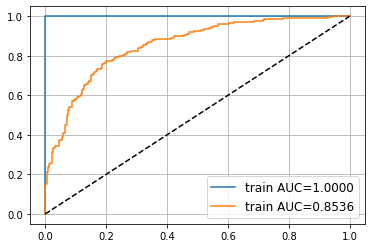

In [18]:
from sklearn.metrics import roc_auc_score,roc_curve

for name, X, y, model in [('train', X_train_bow, target_train, bow_model),
                          ('train', X_test_bow, target_test, bow_model)]:
    probability = model.predict_proba(X)[:,1]
    auc         = roc_auc_score(y,probability)
    plt.plot(*roc_curve(y, probability)[:2] , label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

In [19]:
!pip install torch

In [20]:
# *Using pytorch
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from sklearn.metrics import accuracy_score

from utils import plot_train_process

In [21]:
pytorch_model = nn.Linear(VOCABULARY_SIZE, 2)

pytorch_model.add_module(name = 'dropout_layer',
                         module = nn.Dropout2d(p=.23))
# pytorch_model.add_module?

In [22]:
loss_function = nn.CrossEntropyLoss()

In [23]:
optimizer = torch.optim.SGD(pytorch_model.parameters(),
                           lr = 0.001,
                           momentum=0.9,
                           nesterov=True)
# torch.optim.SGD?

In [24]:
X_train_bow_torch = torch.tensor(X_train_bow, dtype  = torch.float32)
X_test_bow_torch  = torch.tensor(X_test_bow, dtype   = torch.float32)

y_train_torch     = torch.tensor(target_train.values, dtype = torch.long)
y_test_torch      = torch.tensor(target_test.values, dtype  = torch.long)

In [25]:
loss_function(pytorch_model(X_train_bow_torch[:3]), y_train_torch[:3])

tensor(1.4649, grad_fn=<NllLossBackward>)

In [26]:
def train_model(
    model,
    opt,
    lr_scheduler,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=222,
    warm_start=False,
    show_plots=True,
    eval_every=10
):
    if not warm_start:
        for name, module in model.named_children():
            print('resetting ', name)
            try:
                module.reset_parameters()
            except AttributeError as e:
                print('Cannot reset {} module parameters: {}'.format(name, e))

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        # sample random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
         
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch)                                                                                       ### YOUR CODE

        # compute loss, just like before
        loss = loss_function(y_predicted, y_batch)                                                                          ### YOUR CODE

        # compute gradients
        loss.backward()                                                                                                     ### YOUR CODE

        # optimizer step
        opt.step()                                                                                                          ### YOUR CODE

        # clear gradients
        opt.zero_grad()                                                                                                     ### YOUR CODE

        local_train_loss_history.append(loss.data.numpy())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)
            lr_scheduler.step(train_loss_history[-1])

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

In [27]:
lr_scheduler = ReduceLROnPlateau(optimizer)
# ReduceLROnPlateau?

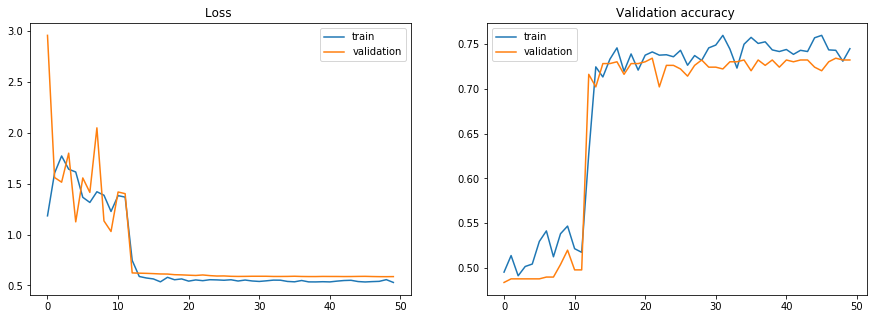

Linear(
  in_features=5080, out_features=2, bias=True
  (dropout_layer): Dropout2d(p=0.23, inplace=False)
)

In [28]:
from IPython import display 

train_model(pytorch_model,
           optimizer,
           lr_scheduler,
           X_train_bow_torch,
           y_train_torch,
           X_test_bow_torch,
           y_test_torch)

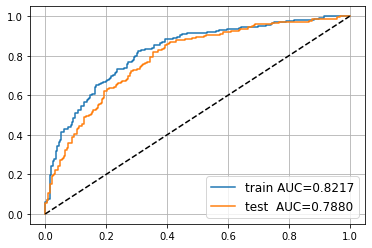

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow_torch, target_train, pytorch_model),
    ('test ', X_test_bow_torch, target_test, pytorch_model)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Vary the number of tokens.

_What are tokens?_ Sentences in the text.

In [30]:
len(word_to_index), VOCABULARY_SIZE

(5080, 5080)

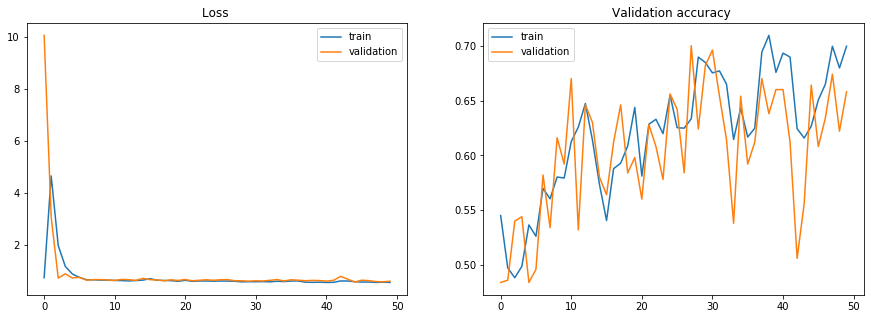

Sequential(
  (0): Linear(in_features=5080, out_features=2, bias=True)
  (dropout): Dropout2d(p=0.43, inplace=False)
)

In [31]:
token_1 = np.random.choice(vocabulary_of_frequent_words, 
                           np.random.randint(222, VOCABULARY_SIZE)).tolist()
VOCABULARY_SIZE_ = len(token_1)

token_to_index_1 = {token:idx for idx,token in enumerate(token_1)}

X_train_bow_1 = np.stack(list(map(text_to_bow, text_train)))
X_test_bow_1  = np.stack(list(map(text_to_bow, text_test)))

new_model = nn.Sequential(nn.Linear(VOCABULARY_SIZE, 
                                    2 )
                         ) #Linear(x, y) -> return y = mx+c
new_model.add_module('dropout', nn.Dropout2d(p = .43)) #Regularization technique
# new_model.add_module('conv2d',nn.Conv2d((len_tokens[0])//2,
#                                         2,
#                                         2)) #Conv1d(in,out,kernel) -> return signal of shape out 
# new_model.add_module('relu2',nn.ReLU(2))   #ReLU(input) -> return max(0, input)

new_optimizer = torch.optim.Adamax(new_model.parameters())

new_lr_scheduler = torch.optim.lr_scheduler.StepLR(new_optimizer,
                                                  step_size=22,
                                                  gamma=0.01)

train_model(new_model,
           new_optimizer,
           new_lr_scheduler,
           X_train_bow_torch,
           y_train_torch,
           X_test_bow_torch,
           y_test_torch)

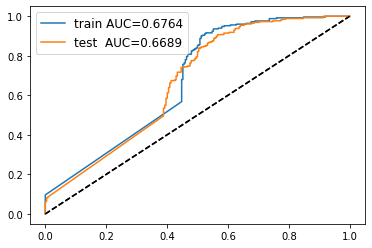

In [32]:
  for name, X, y, model in [
    ('train', X_train_bow_torch, y_train_torch, new_model),
    ('test ', X_test_bow_torch, y_test_torch, new_model)
    ]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large')
    plt.grid()

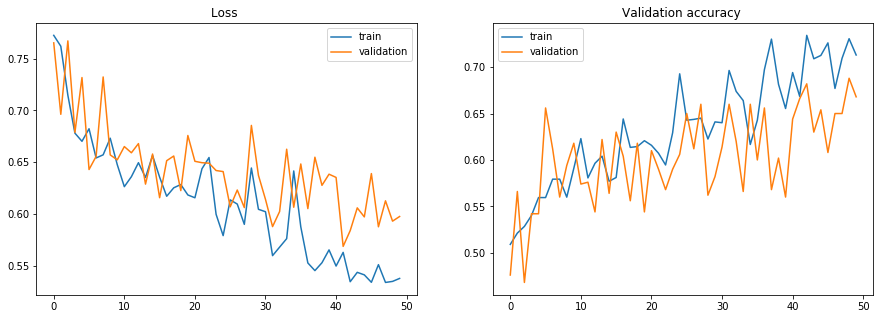

Sequential(
  (0): Linear(in_features=5080, out_features=2, bias=True)
  (dropout): Dropout2d(p=0.43, inplace=False)
)

In [33]:
token_2 = np.random.choice(vocabulary_of_frequent_words, 
                           np.random.randint(222, VOCABULARY_SIZE)).tolist()
VOCABULARY_SIZE_ = len(token_2)

token_to_index_2 = {token:idx for idx,token in enumerate(token_2)}

X_train_bow_2 = np.stack(list(map(text_to_bow, text_train)))
X_test_bow_2  = np.stack(list(map(text_to_bow, text_test)))

train_model(new_model,
           new_optimizer,
           new_lr_scheduler,
           X_train_bow_torch,
           y_train_torch,
           X_test_bow_torch,
           y_test_torch)

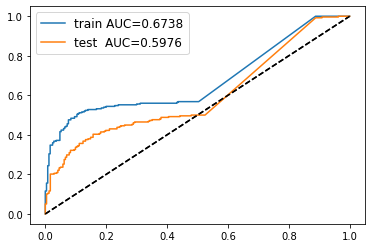

In [34]:
  for name, X, y, model in [
    ('train', X_train_bow_torch, y_train_torch, new_model),
    ('test ', X_test_bow_torch, y_test_torch, new_model)
    ]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large')
    plt.grid()

Implement tf-idf features

_TF_IDF_ (Term Frequency, Inverse Document Frequency)

                                TASK
1. Implement TF-IDF 
2. Train a model
3. Evaluate ROC curve
4. Compare to BOW from above

In [35]:
# -------------------------- 1. Implement TF-IDF
texts_train_, texts_test_, y_train_, y_test_ = train_test_split(text, target, test_size=0.5, random_state=12)

texts_test_ = list(map(preprocessing, texts_test_))
texts_train_ = list(map(preprocessing, texts_train_))

text_test = [sentence.split(' ') for sentence in texts_test_]
text_train = [sentence.split(' ') for sentence in texts_train_]

In [36]:
# Compute tf map
def computeTFDict(text):
    """computes the TF score for each word in the corpus, by document
    """
    TFDict = {}
    for word in text:
        if word in TFDict:
            TFDict[word] += 1
        else:
            TFDict[word] = 1
    # Computes tf for each word
    for word in TFDict:
        TFDict[word] = TFDict[word] / len(text)
    return TFDict

test_tfDict = [computeTFDict(texts_test_datum) for texts_test_datum in text_test]
train_tfDict = [computeTFDict(texts_train_datum) for texts_train_datum in text_train]

# Count the occurance of words in the dictionary
def computeCount(TFDict):
    count = {}
    for text in TFDict:
        for word in text:
            if word in count:
                count[word] += 1
            else:
                count[word] = 1
    return count

test_wordCount = computeCount(test_tfDict)
train_wordCount = computeCount(train_tfDict)

# Compute idf
def computeIDFDict(text_data, wordCount):
    # Computes the IDF score of every word in the corpus.
    IDFDict = {}
    for word in wordCount:
        IDFDict[word] = np.log(len(text_data)/ wordCount[word])
    return IDFDict

test_idfDict = computeIDFDict(text_test, test_wordCount)
train_idfDict = computeIDFDict(text_train, train_wordCount)

# TF-IDF(term) = TF(term) * IDF(term)
def computeTFIDFDict(TFDict, IDFDict):
    TFIDFDict = {}
    #For each word , we multiply its tf and its idf.
    for word in TFDict:
        TFIDFDict[word] = TFDict[word] * IDFDict[word]
    return TFIDFDict

test_tfidfDict = [computeTFIDFDict(test_tfDict_item, test_idfDict) for test_tfDict_item in test_tfDict]
train_tfidfDict = [computeTFIDFDict(train_tfDict_item, train_idfDict) for train_tfDict_item in train_tfDict]

# Build a matrix, each representing a tf of each word in the text
def computeTFIDFVector(text, text_wordCount):
    TFIDFVector = [0.0] * len(text_wordCount)

    for idx, word in enumerate(text_wordCount):
        if word in text:
            TFIDFVector[idx] = text[word]
    return TFIDFVector

test_words = sorted(test_wordCount.keys())
train_words = sorted(train_wordCount.keys())

test_tfidfVector = [computeTFIDFVector(test_tfidfDict_item, test_words) for test_tfidfDict_item in test_tfidfDict]
train_tfidfVector = [computeTFIDFVector(test_tfidfDict_item, test_words) for test_tfidfDict_item in test_tfidfDict]

In [37]:
X_train_tfidf_torch = torch.tensor(train_tfidfVector, dtype=torch.float32)  
X_test_tfidf_torch  = torch.tensor(test_tfidfVector, dtype=torch.float32)   

y_train_torch_ = torch.tensor(y_train_.values, dtype=torch.long)                        
y_test_torch_  = torch.tensor(y_test_.values, dtype=torch.long) 

In [38]:
len(X_train_tfidf_torch), len(y_train_torch_)

(500, 500)

In [39]:
ASS_1_SIZE = X_train_tfidf_torch.shape[1]

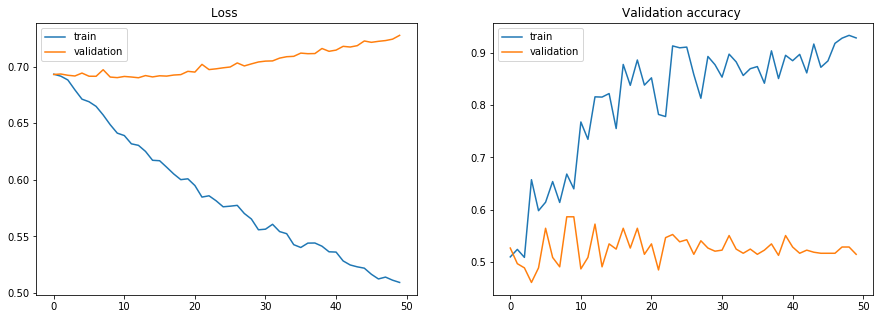

Linear(
  in_features=5451, out_features=2, bias=True
  (dropout): Dropout(p=0.23, inplace=False)
)

In [40]:
# -------------------------- 2. Train a model

new_model_1 = nn.Linear(ASS_1_SIZE,2)
new_model_1.add_module('dropout', nn.Dropout(p = .23))

new_optimizer_1 = torch.optim.SGD(new_model_1.parameters(), lr = 0.09, momentum=0.9)

new_lr_scheduler_1 = ReduceLROnPlateau(new_optimizer_1)

new_model_1.eval()
train_model(new_model_1,
            new_optimizer_1,
            new_lr_scheduler_1,
            X_train_tfidf_torch, 
            y_train_torch_, 
            X_test_tfidf_torch, 
            y_test_torch_)

# new_model.eval?

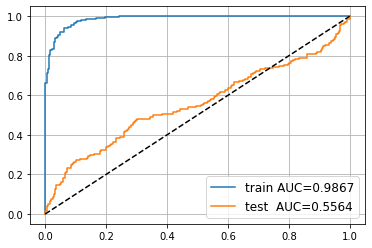

In [41]:
# ----------------------------- 3. ROC Curve

for name, X, y, model in [
    ('train', X_train_tfidf_torch, y_train_torch_, new_model_1),
    ('test ', X_test_tfidf_torch, y_test_torch_, new_model_1)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

                            Compare with naive Baye's
1. Build naive bayes model
2. i. Fit with BOW
2. ii. Fit with tfidf
3. Create LogisticRegression model
4. Train with BOW
5. Train with tfidf
6. Compare results woth ROC

In [42]:
# -------------------- 1. Build naive bayes model

from sklearn.naive_bayes import GaussianNB

naive_bayes_model = GaussianNB()
# GaussianNB?

In [43]:
# ---------------------2.i. Fit with BOW

naive_bayes_bow = naive_bayes_model.fit(X_train_bow_torch, 
                                        y_train_torch).predict(X_test_bow_torch)

In [44]:
# ---------------------2. ii. Fit with tfidf

naive_bayes_tfidf = naive_bayes_model.fit(X_train_tfidf_torch, 
                                          y_train_torch_).predict(X_test_tfidf_torch)

In [45]:
# --------------------- 3. Create LogisticRegression model

from sklearn.linear_model import LogisticRegression

logistic_regression_model = LogisticRegression()
# LogisticRegression?

In [46]:
# ---------------------- 4. Train with BOW

logistic_regression_bow = logistic_regression_model.fit(X_train_bow_torch, 
                                                        y_train_torch)

In [47]:
# ---------------------- 5. Train with tfidf

logistic_regression_tfidf = logistic_regression_model.fit(X_train_tfidf_torch, 
                                                          y_train_torch_)

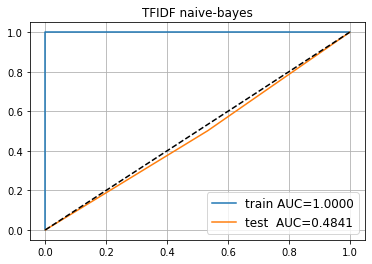

In [48]:
# ----------------------- 6. Compare results woth ROC
# ---- tfidf naive bayes
for name, X, y, model in [
    ('train', X_train_tfidf_torch, y_train_torch_, naive_bayes_model),
    ('test ', X_test_tfidf_torch, y_test_torch_, naive_bayes_model)
]:
    auc = roc_auc_score(y, naive_bayes_tfidf)
    plt.plot(*roc_curve(y, naive_bayes_tfidf)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.title('TFIDF naive-bayes')
plt.grid()

__Yikes.__ \
___There was overfitting.___

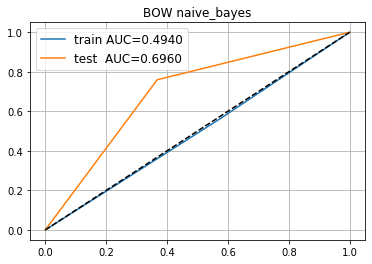

In [49]:
# ---- bow naive bayes


for name, X, y, model in [
    ('train', X_train_bow_torch, y_train_torch, naive_bayes_model),
    ('test ', X_test_bow_torch, y_test_torch, naive_bayes_model)
]:
    auc = roc_auc_score(y, naive_bayes_bow)
    plt.plot(*roc_curve(y, naive_bayes_bow)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.title('BOW naive_bayes')
plt.grid()



___Better test results than train___